In [1]:
import os
import re
import numpy as np

%load_ext autoreload
%autoreload 2

try:
  import pytorch_lightning as pl
except: 
  !pip install pytorch-lightning==1.2.10
  import pytorch_lightning as pl

try:
  import torchplot
except: 
  !pip install torchplot
  import torchplot
    
try:
    from Bio import SeqIO
except:
    !pip install biopython
    from Bio import SeqIO
    
# Download repo if notebook is taken out of context (e.g. by colab)
if not os.path.exists('models'):
    !git clone https://github.com/MachineLearningLifeScience/What-is-a-meaningful-representation-of-protein-sequences tmp_clone
    !mv tmp_clone/* .
    !rm -rf tmp_clone

if not os.path.exists('PF00144_full_labeled.fasta'):
    !wget https://sid.erda.dk/share_redirect/a5PTfl88w0/PF00144_full_labeled.fasta

# Load VAE models

In [2]:
import numpy as np
import pytorch_lightning as pl
import torch
import torch.nn.functional as F

from models.vae_geometric import VAE, get_hparams, aa1_to_index, aa1, curve_energy, numeric_curve_optimizer

def get_data(data_filename, calc_weights=True, similarity_threshold=0.8):
    ids = []
    labels = []
    seqs = []
    label_re = re.compile(r'\[([^\]]*)\]')
    for record in SeqIO.parse(data_filename, "fasta"):
        ids.append(record.id)
        labels.append(label_re.search(record.description).group(1))
        seqs.append(np.array([aa1_to_index[aa] for aa in str(record.seq).upper().replace('.', '-')]))
        
    seqs = torch.from_numpy(np.vstack(seqs))
    labels = np.array(labels)

    weights = None
    if calc_weights is not False:

        # Experiencing memory issues on colab for this code because pytorch doesn't
        # allow one_hot directly to bool. Splitting in two and then merging.
        # one_hot = F.one_hot(seqs.long()).to('cuda' if torch.cuda.is_available() else 'cpu')
        one_hot1 = F.one_hot(seqs[:len(seqs)//2].long()).bool()
        one_hot2 = F.one_hot(seqs[len(seqs)//2:].long()).bool()
        one_hot = torch.cat([one_hot1, one_hot2]).to('cuda' if torch.cuda.is_available() else 'cpu')
        assert(len(seqs) == len(one_hot))
        del one_hot1
        del one_hot2
        one_hot[seqs>19] = 0
        flat_one_hot = one_hot.flatten(1)

        weights = []
        weight_batch_size = 1000
        flat_one_hot = flat_one_hot.float()
        for i in range(seqs.size(0) // weight_batch_size + 1):
            x = flat_one_hot[i * weight_batch_size : (i + 1) * weight_batch_size]
            similarities = torch.mm(x, flat_one_hot.T)
            lengths = (seqs[i * weight_batch_size : (i + 1) * weight_batch_size] <=19).sum(1).unsqueeze(-1).to('cuda' if torch.cuda.is_available() else 'cpu')
            w = 1.0 / (similarities / lengths).gt(similarity_threshold).sum(1).float()
            weights.append(w)
            # plt.hist(similarities/lengths)
            
        weights = torch.cat(weights)
        neff = weights.sum()

    return ids, seqs, labels, weights

# Note that we deviate from the normal choice of 0.8 for the similarity threshold. This is 
# Due to the PFAM alignment being extremely long, with lots of positions matching gaps.
ids, data, labels, weights = get_data("PF00144_full_labeled.fasta", calc_weights=True, similarity_threshold=0.6)
print(weights)

#import matplotlib.pyplot as plt
#plt.hist(weights, bins=100)

None


In [3]:
import time
def train_or_retrieve_model(name, data, weights, train_model, uncertainty_temperature):
    
    cmd_args = []
    if train_model:
        cmd_args += ['-gpu', '1' if torch.cuda.is_available() else '']
    else:
        cmd_args += ['-load_from', name+'.ckpt', '-gpu', '1' if torch.cuda.is_available() else '']
    hparams = get_hparams(cmd_args)

    pl.seed_everything(hparams.seed)

    perm = np.random.permutation(data.shape[0])
    
    if hparams.load_from!='':
        
        if not os.path.exists(hparams.load_from):
            filename = os.path.join('https://sid.erda.dk/share_redirect/a5PTfl88w0/', hparams.load_from)
            !wget $filename
        
        print('Loading from checkpoint!')
        model = VAE.load_from_checkpoint(checkpoint_path=hparams.load_from, data=data, perm=perm, weights=weights)

        # for some reason these where not correctly saved in the checkpoint
        model.switch = True
        
        # Trigger retraining of distnet, since this does not seem to be saved properly in checkpoint
        model.distnet.initialized = False
        
        # Model fit specific parameter setting the temperature of the uncertainty
        model.distnet.trans.beta.data = torch.tensor([uncertainty_temperature])
        
    else:
        print('Training model!')
        model = VAE(data=data, weights=weights, perm=perm, hparams=hparams)
        trainer = pl.Trainer(gpus=1 if hparams.gpu else 0,
                             max_epochs=hparams.epochs)
        trainer.fit(model)
        
        trainer.save_checkpoint(name+'_{}.ckpt'.format(time.strftime("%Y%m%d")))

    return model

In [5]:
# Options
train_models = False

model_pf00144 = train_or_retrieve_model('model_PF00144_new_20210923', 
                                        data,
                                        weights=None,
                                        train_model=train_models,
                                        uncertainty_temperature=-3.5)
model_pf00144_reweighted = train_or_retrieve_model('model_PF00144_reweighted_0.6', 
                                                   data,
                                                   weights=weights,
                                                   train_model=train_models,
                                                   uncertainty_temperature=-3.5)
models = [model_pf00144, model_pf00144_reweighted]

Loading from checkpoint!
Loading from checkpoint!


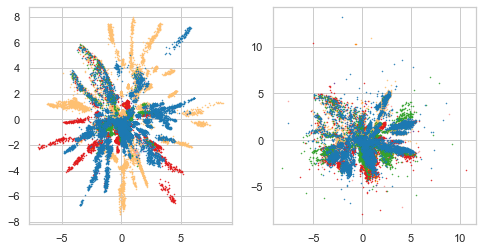

In [82]:
embeddings = []
for model in [model_pf00144, model_pf00144_reweighted]:
    embeddings.append([])
    batchsize = 16
    n_batch = int(np.ceil(model.data.shape[0] / batchsize))
    for b in range(n_batch):
        batch = model.data[b*batchsize:(b+1)*batchsize]
        zs = model.embedding(batch.long().to(model._device))
        embeddings[-1].append(zs.detach())
    embeddings[-1] = np.vstack(embeddings[-1])
    

phyla = ['Acidobacteria', 'Actinobacteria', 'Bacteroidetes',
         'Chloroflexi', 'Cyanobacteria', 'Deinococcus-Thermus',
         'Firmicutes', 'Fusobacteria', 'Proteobacteria']#, 'Other']
            
import matplotlib.pyplot as plt

# Color coding of organisms
colors = [[106,61,154],
          [254,192,113],
          [226,28,29],
          [250,155,153],
          [252,129,2],
          [168,206,227],
          [51,162,45],
          [179,225,139],
          [28,121,179],
          [193,193,193]]
colors = np.array(colors) / 255.0
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
for idx,_ in enumerate(embeddings):
    for i in range(len(phyla)):
        ax[idx].plot(embeddings[idx][labels==phyla[i],0],
                     embeddings[idx][labels==phyla[i],1],
                     '.', color=colors[i], label=phyla[i], markersize=1)    


# Entropy plot

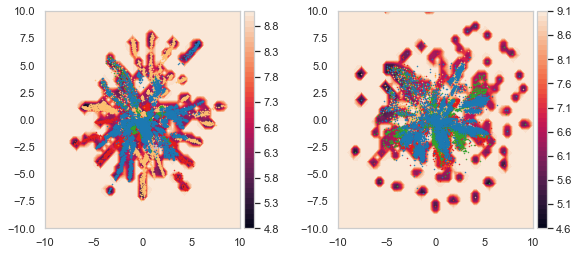

In [83]:
import torch.distributions as D
from mpl_toolkits.axes_grid1 import make_axes_locatable

n_points = 50
xy_min, xy_max = -10,10

z_grid = torch.stack([m.flatten() for m in torch.meshgrid(2*[torch.linspace(xy_min,xy_max,n_points)])]).t()

fig, ax = plt.subplots(1, 2, figsize=(9, 4))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=None)
for idx, model in enumerate(models):
    recon = models[idx].decode(z_grid, as_probs=True)
    d = D.Categorical(probs=recon.permute(0,2,1))
    # d = D.Categorical(probs=recon[:,:-1,:].permute(0,2,1))
    var1 = d.entropy().sum(dim=-1)

    for i in range(len(phyla)):
        ax[idx].plot(embeddings[idx][labels==phyla[i],0],
                 embeddings[idx][labels==phyla[i],1],
                 '.', color=colors[i], label=phyla[i], markersize=1)   
    c = ax[idx].contourf(z_grid[:,0].reshape(n_points, n_points),
                  z_grid[:,1].reshape(n_points, n_points),
                  var1.log().reshape(n_points, n_points).detach(), levels=50)
    ax[idx].set_xlim([xy_min, xy_max])
    ax[idx].set_ylim([xy_min, xy_max])

    divider = make_axes_locatable(ax[idx])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(c, cax=cax, orientation='vertical')
    #ax[idx].colorbar()
    #ax[idx].axis('off')


# Phylogenetic tree

In [61]:
# Options
run_preprocessing = False
n_samples = 500

phylo_ids = []
for record in SeqIO.parse('PF00144_full_labeled.fasta', "fasta"):
    phylo_ids.append(record.id.split('/')[0])
    
if run_preprocessing:

    !FastTree &> /dev/null
    if exit_code != 0:
                    
        # Attempt at making script self-contained by installing FastTree via conda. 
        # Seems to work on colab, but might not be super robust
        !conda --version
        if _exit_code != 0:
            !pip install -q condacolab
            import condacolab
            condacolab.install()
        
        !conda install -c bioconda fasttree 
    
    # Estimate tree
    !FastTree < PF00144_full.txt > PF00144_tree.txt

else:
    # Retrieve Beta-lactamase tree file
    if not os.path.exists('PF00144_tree.txt'):
        !wget https://sid.erda.dk/share_redirect/a5PTfl88w0/PF00144_tree.txt    
    

In [63]:
try:
    from Bio import Phylo
except:
    !pip install biopython
    from Bio import Phylo

class TreeDist(object):
    def __init__(self, filename):
        self.tree = next(Phylo.parse(filename, 'newick'))
        self.leaves = list(self.tree.get_terminals())
        
        self.leaf_lookup = {}
        for i, leaf in enumerate(self.leaves):
            self.leaf_lookup[leaf.name] = i

    def id_to_id_dist(self, id1, id2):

        idx1 = self.leaf_lookup[id1]
        idx2 = self.leaf_lookup[id2]

        return self.tree.distance(self.leaves[idx1],
                                  self.leaves[idx2])
    
td = TreeDist("PF00144_tree.txt")

print("Leaves: ", len(td.leaves))

Leaves:  36328


In [84]:
import scipy.stats
import pandas as pd

dms = []
for model in models[:1]:
    # Create grid and calculate discretized version of manifold, so that geodesics can be calculated using
    # graph algorithm
    n_points = 100
    z_grid = torch.stack([m.flatten() for m in torch.meshgrid(2*[torch.linspace(-10,10,n_points)])]).t()

    from models.geoml.manifold import EmbeddedManifold, CubicSpline
    from models.geoml.discretized_manifold import DiscretizedManifold
    print('\n Creating discretized manifolds')
    dms.append(DiscretizedManifold(model, z_grid.t().reshape(2,n_points,n_points), use_diagonals=True))


 Creating discretized manifolds


In [93]:
n_repetitions = 1
distances = []
for i in range(n_repetitions):
    
    # Random indices
    # weight sampling by each points norm to center
    sample_idx_i = []
    sample_idx_j = []
    for j,model in enumerate(models):
        weights = softmax(np.linalg.norm(embeddings[j], ord=2, axis=-1))
        sample_idx_i.append(np.random.choice(len(data), size=n_samples, replace=False, p=weights))
        sample_idx_j.append(np.random.choice(len(data), size=n_samples, replace=False, p=weights))
    
    print('\n Calculating phylogenetic distances')
    phylo_distances = []
    for i, j in zip(sample_idx_i[0], sample_idx_j[0]):
        phylo_distances.append(td.id_to_id_dist(ids[i], 
                                                ids[j]))
        
    print('\n Calculating VAE distances')
    vae_distances = []
    for i, j in zip(sample_idx_i[0], sample_idx_j[0]):
        em1 = embeddings[0][i]
        em2 = embeddings[0][j]
        vae_distances.append(np.linalg.norm(em1-em2))

    print('\n Calculating VAE geodesics')
    vae_geo_distances = []
    for i, j in zip(sample_idx_i[0], sample_idx_j[0]):
        em1 = embeddings[0][i]
        em2 = embeddings[0][j]
        #curve, dist = dms[0].shortest_path(em1, em2)
#         curve = dms[0].connecting_geodesic(torch.tensor(em1).reshape(1,-1), torch.tensor(em2).reshape(1,-1),
#                                            CubicSpline(torch.tensor(em1).reshape(1,-1), torch.tensor(em2).reshape(1,-1), num_nodes=10))
        curve = dms[0].connecting_geodesic(torch.tensor(embeddings[0][i]).reshape(1,-1),
                                           torch.tensor(embeddings[0][j]).reshape(1,-1))
        dist = float(models[0].curve_length(curve(torch.linspace(0, 1, 100))))
#     curve, dist = dms[0].shortest_path(torch.tensor(embeddings[0][i]),
#                                    torch.tensor(embeddings[0][j]))
#     curve = dms[0].connecting_geodesic(torch.tensor(embeddings[0][i]).reshape(1,-1),
#                                    torch.tensor(embeddings[0][j]).reshape(1,-1))
#     curve = numeric_curve_optimizer(models[0], curve)        
        vae_geo_distances.append(dist)
        
    print('\n Calculating VAE (reweighted) distances')
    vae_distances_w = []
    for i, j in zip(sample_idx_i[1], sample_idx_j[1]):
        em1 = embeddings[1][i]
        em2 = embeddings[1][j]
        vae_distances_w.append(np.linalg.norm(em1-em2))

    print('\n Calculating Hamming distances')
    hamming_distances = []
    for i, j in zip(sample_idx_i[0], sample_idx_j[0]):
        hamming_distances.append(scipy.spatial.distance.hamming(data[i], data[j]))
        
    distances.append({'phylo':phylo_distances, 
                      'vae':vae_distances, 
                      'vae_geo':vae_geo_distances, 
                      'vae_w':vae_distances_w, 
                      'hamming':hamming_distances})
distances = pd.DataFrame(distances)


 Calculating phylogenetic distances

 Calculating VAE distances

 Calculating VAE geodesics

 Calculating VAE (reweighted) distances

 Calculating Hamming distances


vae Pearson: 0.65 ± 0.00
Spearman: 0.59 ± 0.00
vae_geo Pearson: -0.21 ± 0.00
Spearman: -0.14 ± 0.00
vae_w Pearson: -0.08 ± 0.00
Spearman: -0.06 ± 0.00
hamming Pearson: 0.81 ± 0.00
Spearman: 0.56 ± 0.00


<ipython-input-94-41a3a04de50d>:54: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coeff_a, _, _, _ = np.linalg.lstsq(x[:,np.newaxis], y)
<ipython-input-94-41a3a04de50d>:54: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coeff_a, _, _, _ = np.linalg.lstsq(x[:,np.newaxis], y)
<ipython-input-94-41a3a04de50d>:54: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pa

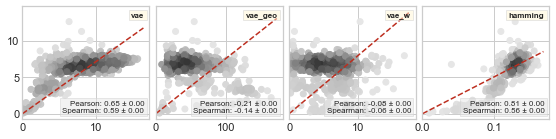

In [94]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
from scipy.stats import gaussian_kde
import matplotlib.colors as colors
import scipy.stats
import seaborn as sns
sns.set_theme(style="whitegrid")

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

red = [.74, .18, .12]
yellow = "#fff6d5"
cmap = truncate_colormap(plt.get_cmap('gray_r'), 0.1, 0.80)


fig, ax = plt.subplots(1, len(distances.columns)-1, sharex=False, sharey=True, figsize=(8,2.))
plt.subplots_adjust(wspace=0.05, hspace=0.0, left=0.075, right=0.99, bottom=0.2, top=0.98)

for idx, model in enumerate(distances.loc[:, distances.columns != 'phylo']):
    
    xs = np.array(distances[model].to_list())
    ys = np.array(distances['phylo'].to_list())
    
    spearmans = []
    pearsons = []
    for repetition in range(xs.shape[0]):
        
        x = xs[repetition]
        y = ys[repetition]
        
        spearmans.append(scipy.stats.spearmanr(x, y).correlation)
        pearsons.append(np.corrcoef(x,y)[0,1])

    corr_str = """Pearson: {:.2f} ± {:.2f}\nSpearman: {:.2f} ± {:.2f}""".format(np.mean(pearsons), 
                                                                                np.std(pearsons), 
                                                                                np.mean(spearmans), 
                                                                                np.std(spearmans))
    
    print(model, corr_str)
    
    # Visualize first repetition
    x = xs[0]
    y = ys[0]
    
    xy = np.vstack([x,y])

    z = gaussian_kde(xy)(xy)


    title = model

    ax[idx].scatter(x, y, c=z, cmap=cmap)

    line_x = np.linspace(0, ax[idx].get_xlim()[1], 500)

    #coeff_a, _, _, _ = np.linalg.lstsq(x[:,np.newaxis], y)
    #line_y = coeff_a*line_x
    coef = np.polyfit(x,y,1)
    line_y = np.poly1d(coef)
    
    ax[idx].plot(line_x, line_y, '--', color=red)

    ax[idx].tick_params(axis='both', which='major', pad=-3)
    
    props = dict(boxstyle='square', facecolor=yellow, edgecolor='lightgrey', alpha=0.5, )

    ax[idx].text(0.96, 0.95, title, transform=ax[idx].transAxes, fontsize=8,
               verticalalignment='top', horizontalalignment='right', bbox=props, fontweight='bold')

    props = dict(boxstyle='square', facecolor="0.9", edgecolor='lightgrey', alpha=0.5)

    ax[idx].text(0.96, 0.05, corr_str, transform=ax[idx].transAxes, fontsize=8,
               verticalalignment='bottom', horizontalalignment='right', bbox=props)

    ax[idx].set_xlim(left=0)

# Ancestral reconstruction

In [ ]:
# Options
run_preprocessing = False

representative_point_labels = ['A0A1S9B261_9BACT', 'A0A1N6S5V9_9SPHI', 'A0A0G3XB70_9SPHN', 'A0A124H8F2_9ACTN', 'A0A0H0XMZ2_9SPHN', 'A0A1H3MS29_9MICO', 'A0A1C4RXZ6_9ACTN', 'K6YB53_9ALTE', 'D7BUJ0_STRBB', 'V4PEL1_9CAUL', 'A0A0R2T7U0_9GAMM', 'W6TRC3_9SPHI', 'A0A095V1K0_9FLAO', 'H5UKC9_9ACTN', 'A0A086GHA9_STRSC', 'I0K217_9BACT', 'A0A1E5SZ29_9BACT', 'A0A162YSP3_9FLAO', 'A0A1J4NQQ5_9ACTN', 'U5VSN6_9ACTN', 'A0A1C4SSD9_9ACTN', 'A0A1W9IDH3_9PROT', 'A0A142HQP5_9SPHI', 'A0A1S1R3M6_9ACTN', 'A0A1I1BJF2_9RHIZ', 'U5EQF0_NOCAS', 'A0A0X3XPR2_9ACTN', 'H6R079_NOCCG', 'A0A117P596_9ACTN', 'A0A1A1WA84_9MYCO', 'A0A0P1E0C4_9RHOB', 'A0A1A1W888_9MYCO', 'A0A1H7JGC4_9FLAO', 'A0A239H288_9ACTN', 'A0A1Q3TL54_9SPHI', 'K4KU84_SIMAS', 'A0A1I5UY06_9BURK', 'R1I1M6_9PSEU', 'Q1QJW4_NITHX', 'A0A132PRK9_9MYCO', 'A0A1U9RJ97_9PROT', 'A0A1M7RYP7_9SPHN', 'A0A1B2AFT2_9SPHN', 'A0A0A0M5Y1_9GAMM', 'A0A0F5VWV8_9ACTN', 'I2GLG1_9BACT', 'A0A0F7FX81_9ACTN', 'A0A1G8H815_9FLAO', 'A0A1X1XXI8_9MYCO', 'A0A239D989_9ACTN', 'A0A1V6MS15_9ACTN', 'A0A1H5P1R8_9ACTN', 'A0A1I5FZY5_9PSEU', 'A0A0X8G8M6_9FLAO', 'A0A0B4C4Z4_9RHOB', 'A0A1A3JFC6_9MYCO', 'F6FTL6_ISOV2', 'R6TPJ2_9FIRM', 'A0A0A8E0Q6_9XANT', 'A0A1I7E112_9BURK', 'A0A1I0K8Y1_9ACTN', 'A0A1Q5RAV8_9BRAD', 'A6GGG0_9DELT', 'F9UGM4_9GAMM', 'C1AR94_RHOOB', 'A0A1M5PIZ9_9PSED', 'A4YSH1_BRASO', 'A0A1C5D6B7_9ACTN', 'A0A1B9SCE0_9RHIZ', 'A0A1H5RFB9_9PSEU', 'A0A1H6K407_9FLAO', 'A0A1I5LQF8_9PSEU', 'A0A101P567_9ACTN', 'A0A1W9HH69_9PROT', 'A0A1C5GGB8_9ACTN', 'A0A1H9UFK4_9PSEU', 'C6XX09_PEDHD', 'A0A1N7D2Y2_9SPHI', 'A0A0M9ZF93_9ACTN', 'A0A1I3JVY2_9FLAO', 'A0A1Q5XM94_9BACL', 'A0A086GTC1_STRSC', 'A0A0Q3PHY5_9BRAD', 'X5L994_9MYCO', 'A8FUC9_SHESH', 'A0A1Q4AJT7_9RHIZ', 'A0A1R0U5T5_9MYCO', 'A0A239E4N3_9SPHN', 'A0A1W9Z6U0_9MYCO', 'A0A1E7N9T9_KITAU', 'A0A0D8ZT94_9CYAN', 'U5W069_9ACTN', 'A0A1X1TEX7_9MYCO', 'E3IVP0_FRAIE', 'A0A238W6P2_9FLAO', 'A0A0S2KGP0_9GAMM', 'A0A150X572_9BACT', 'A0A0P1HDX4_9RHOB', 'A0A1X1Y8Z0_9MYCO', 'A0A1T3NKX6_9ACTN', 'A0A1E5T8M3_9FLAO', 'W6RMK2_9RHIZ', 'D2QF15_SPILD', 'A0A172YP11_9GAMM', 'A0A1G9IS36_9FIRM', 'A0A0P0NER0_9SPHI', 'A0A1H2Z8U6_9FLAO', 'I4N9E9_9PSED', 'H6NNS0_9BACL', 'A0A0Q6U7Q0_9CAUL', 'A0A1I1NQA5_9FLAO', 'W6K0N3_9MICO', 'A0A059FAG0_9RHOB', 'A0A239UAQ6_9STAP', 'A0A0Q4CCW5_9SPHN', 'A0A1H7Z0C3_9BACL', 'I8XTV4_9BACE', 'A0A0Q9SNL5_9MICO', 'A0A0L0KUC6_9ACTN', 'A0A1M3DBI3_9SPHN', 'A0A0Q4CCV4_9FLAO', 'A0A0Q6LBM4_9RHIZ', 'A0A0D6P7R6_9PROT', 'A0A2D8REK4_9GAMM', 'A0A1I6MH08_9MICO', 'A0A1Z2KUI0_9ACTN', 'A5FKQ3_FLAJ1', 'A0A1I1L7I8_9GAMM', 'A0A1G9VIM6_9PSEU', 'A0A0K2YPP4_9NOCA', 'A0A172ZMD5_9BACL', 'A0A117P8A7_9ACTN', 'A0A0M2VW43_9BACL', 'A0A1X7LEJ3_9BACT', 'A0A1G8MTV3_9BRAD', 'A0A1G9UIX5_9ACTN', 'A0A2G1UKI9_9ALTE', 'A0A1I4ZAY4_9ACTN', 'A0A091BUD4_9ENTE', 'A0A1G9SC39_9BACT', 'A0A117QQC3_9ACTN', 'A0A246JGM2_9SPHN', 'G2YZY5_FLABF', 'A0A1A1XCB1_9MYCO', 'A0A1G6EYF3_9FLAO', 'A0A1W1UTZ2_9DEIO', 'A0A1H0LUA7_9PSEU', 'A0A0D7N702_9BRAD', 'A0A139V867_MYCPH', 'A0A0Q7T9N7_9CAUL', 'A0A075P8I6_9ALTE', 'F5XN73_MICPN', 'A0A1N6TB30_9ACTN', 'A0A0S2F7W1_9GAMM', 'A0A0W1FDQ5_9SPHN', 'A0A1F4HNF0_9BURK', 'A0A0S7B6I6_9CHLR', 'A0A1M7RNK4_9ACTN', 'D9VTC3_9ACTN', 'A0A1I4H5E7_9BACI', 'A0A1I6MHH8_9MICO', 'A0A0N1C0K0_9SPHN', 'A0A0S7BU80_9BACT', 'A0A1E5UCX4_9FLAO', 'A0A0T1QBY4_9ACTN', 'A0A1I7HTB7_9BRAD', 'A0A0J8YTA7_9BACT', 'A0A0Q5LNR9_9MICO', 'W6RC31_9RHIZ', 'A0A1H9IED7_9GAMM', 'A0A2C9XTS2_9ENTE', 'A0A0A7JHS1_9PSED', 'A0A0G3M0P2_9FLAO', 'A0A257J7M5_9PROT', 'A0A0Q4RYS2_9FLAO', 'A0A0X8E1F4_9MICO', 'A0A1H3JYW4_9ACTN', 'A0A1S8D874_9PROT', 'A0A1K2FJD7_9ACTN', 'A0A0M8XWS4_9ACTN', 'A0A1L7D1X1_9CORY', 'A0A0S2K5Z8_9GAMM', 'A0A1C2EAC3_9RHIZ', 'A0A086N7F9_9ACTN', 'A0A172TI00_9BACL', 'A0A1N7N8U5_9RHOB', 'A0A127JZQ8_9BURK', 'A0A0Q4MDP1_9GAMM', 'A0A074M2K7_9SPHN', 'A0A1S6FJP8_9SPHN', 'A0A1R1SC01_9ACTN', 'A0A1A3MVE7_MYCAS', 'B0T1W0_CAUSK', 'A0A0Q5UMQ3_9FLAO', 'K0ELR6_9NOCA', 'C9ZH94_STRSW', 'A0A100Y6W1_9ACTN', 'A0A1H4IQL5_9FLAO', 'A0A0M8XHR7_9ACTN', 'A0A1A1Y6V6_9MYCO']

if run_preprocessing:

    from Bio import AlignIO
    from Bio.Align import MultipleSeqAlignment
    import io
    import copy
    import re
    import numpy as np
    
    # Create small alignment only with representative sequences
    records = []
    counter = 1
    for record in SeqIO.parse("PF00144_full_labeled.fasta", "fasta"):
        if record.id.split('/')[0] in representative_point_labels:
            record.id = "node%02d_%s" % (counter, record.id)
            records.append(record)
            counter += 1
    with open("PF00144_full_representatives.fasta", "w") as output_handle:
        SeqIO.write(records, output_handle, "fasta")

    # Fix gap symbols
    with open("PF00144_full_representatives.fasta") as alignment_file:
        contents = alignment_file.read()
        contents = contents.replace('.', '-')
    alignment = AlignIO.read(io.StringIO(contents), "fasta")

    # Remove columns which have only gaps
    compact_alignment = None
    removed_columns = []
    gap_column = None
    for j in range(alignment.get_alignment_length()):
        if alignment[:,j].count('-') != len(alignment):
            if compact_alignment is None:
                compact_alignment = alignment[:,j:j+1]
            else:
                compact_alignment += alignment[:,j:j+1]
        else:
            removed_columns.append(j)
            gap_column = copy.copy(alignment[:,j:j+1])
    AlignIO.write(compact_alignment, "PF00144_full_representatives_compact.fasta", "fasta")

    # Create tree
    command = "FastTree < %s > %s" % ("PF00144_full_representatives_compact.fasta", 
                                        "PF00144_full_representatives_compact.tree")
    !$command
    
    if not os.path.exists('convert_fasta2phylip.py'):
        !wget https://sid.erda.dk/share_redirect/a5PTfl88w0/convert_fasta2phylip.py
            
    # Convert fasta to phylip
    %run convert_fasta2phylip.py PF00144_full_representatives_compact.fasta PF00144_full_representatives_compact.phy

    # Run codeml from the PAML package
    if not os.path.exists('paml4.9j'):
        !wget http://abacus.gene.ucl.ac.uk/software/paml4.9j.tgz
        !tar xvf paml4.9j.tgz
        %cd paml4.9j/src
        !make
        %cd ../..
        
    # Retrieve codeml control file
    if not os.path.exists('control_file.ctl'):
        !wget https://sid.erda.dk/share_redirect/a5PTfl88w0/control_file.ctl
    
    # Run reconstruction
    !paml4.9j/src/codeml control_file.ctl
    
    # Extract ancestral sequences
    if not os.path.exists('parse_rst'):
        !wget https://sid.erda.dk/share_redirect/a5PTfl88w0/parse_rst
    command = "python parse_rst.py rst > PF00144_full_representatives_compact_ancestral.fasta" 
    !$command

    # Reinsert original gaps
    alignment_compact = AlignIO.read("PF00144_full_representatives_compact_ancestral.fasta", "fasta")
    alignment_final = None
    compact_index = 0
    # gap_column = copy.copy(alignment_compact[:,0])
    # gap_column[:,:] = '-'
    gap_column = gap_column[:len(alignment_compact)]
    for j in range(alignment.get_alignment_length()): # Note, using original alignment here for total length
        print("j=%s" %j)
        if j in removed_columns:
            if alignment_final is None:
                alignment_final = copy.copy(gap_column)
            else:
                alignment_final += copy.copy(gap_column)
        else:
            if alignment_final is None:
                alignment_final = alignment_compact[:,compact_index:compact_index+1]
            else:
                alignment_final += alignment_compact[:,compact_index:compact_index+1]
            compact_index += 1

    for i,row in enumerate(alignment_final):
        row.id = alignment_compact[i].id
        row.description = alignment_compact[i].description

    AlignIO.write(alignment_final, "PF00144_full_representatives_ancestral.fasta", "fasta")

    # Extract edge-info from rst file
    pattern = re.compile(r'\s*(\d+..\d+\s+)+')
    with open("rst") as infile:
        tree_str = pattern.search(infile.read()).group(0)
        ancestral_edges = np.array([[int(element)-1 for element in pair.split('..')] for pair in tree_str.split()])
        np.save("ancestral_edges.npy", ancestral_edges)
    
else:

    if not os.path.exists("PF00144_full_representatives.fasta"):
        !wget https://sid.erda.dk/share_redirect/a5PTfl88w0/PF00144_full_representatives.fasta

    if not os.path.exists("PF00144_full_representatives_ancestral.fasta"):
        !wget https://sid.erda.dk/share_redirect/a5PTfl88w0/PF00144_full_representatives_ancestral.fasta

    if not os.path.exists("ancestral_edges.npy"):
        !wget https://sid.erda.dk/share_redirect/a5PTfl88w0/ancestral_edges.npy


ancestral_ids = []
ancestral_seqs = []
for record in SeqIO.parse("PF00144_full_representatives.fasta", "fasta"):
    ancestral_ids.append(record.id)
    ancestral_seqs.append(np.array([aa1_to_index[aa] for aa in str(record.seq).upper().replace('.', '-')]))
for record in SeqIO.parse("PF00144_full_representatives_ancestral.fasta", "fasta"):
    ancestral_ids.append(record.id)
    ancestral_seqs.append(np.array([aa1_to_index[aa] for aa in str(record.seq).upper().replace('.', '-')]))
ancestral_seqs = torch.from_numpy(np.vstack(ancestral_seqs))

ancestral_embeddings = []
for model in models:
    ancestral_embeddings.append([])
    batchsize = 16
    n_batch = int(np.ceil(ancestral_seqs.shape[0] / batchsize))
    for b in range(n_batch):
        batch = ancestral_seqs.data[b*batchsize:(b+1)*batchsize]
        zs = model.embedding(batch.long().to(model._device))
        ancestral_embeddings[-1].append(zs.detach())
    ancestral_embeddings[-1] = np.vstack(ancestral_embeddings[-1])
    
# Color coding of organisms
colors = [[106,61,154],
          [254,192,113],
          [226,28,29],
          [250,155,153],
          [252,129,2],
          [168,206,227],
          [51,162,45],
          [179,225,139],
          [28,121,179],
          [193,193,193]]
colors = np.array(colors) / 255.0
for i in range(len(phyla)):
    plt.plot(embeddings[0][labels==phyla[i],0],
             embeddings[0][labels==phyla[i],1],
             '.', color=colors[i], label=phyla[i], markersize=1)   

plt.scatter(ancestral_embeddings[0][:,0], ancestral_embeddings[0][:,1], color='black')

ancestral_edges = np.load('ancestral_edges.npy')
for edge in ancestral_edges:
    p1 = ancestral_embeddings[0][edge[0]]
    p2 = ancestral_embeddings[0][edge[1]]
    plt.plot([p1[0], p2[0]], [p1[1], p2[1]], color='black')

# Visualizing geodesics

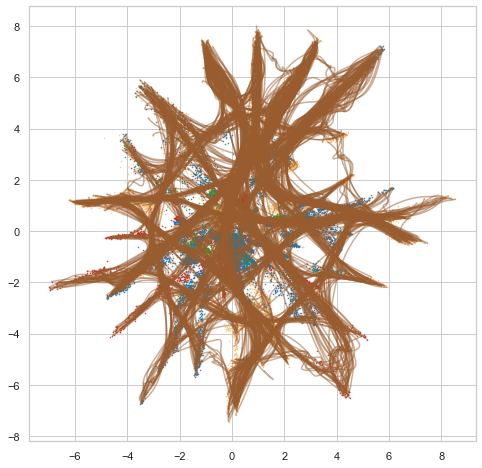

In [99]:
from scipy.special import softmax
from copy import deepcopy

fig = plt.figure(figsize=(8,8))

# def numeric_curve_optimizer(curve):
#     optimizer = torch.optim.Adam([curve.parameters], lr=1e-2)
#     alpha = torch.linspace(0, 1, 50).reshape((-1, 1))
#     best_curve, best_loss = deepcopy(curve), float('inf')
#     for i in range(10):
#         optimizer.zero_grad()
#         loss = curve_energy(model, curve(alpha), 1.0).sum()
#         loss.backward()
#         optimizer.step()
#         grad_size = torch.max(torch.abs(curve.parameters.grad))
#         if grad_size < 1e-3:
#             break
#         if loss.item() < best_loss:
#             best_curve = deepcopy(curve)
#             best_loss = loss.item()

#     return best_curve

# def curve_energy(model, curve, weight=0.0):
#     if curve.dim() == 2:
#         curve.unsqueeze_(0) # BxNxd

#     recon, switch = model.decode(curve, as_probs=True, return_s=True) # BxNxFxS
#     x = recon[:,:-1,:,:]; y = recon[:,1:,:,:];
#     dt = torch.norm(curve[:,1:,:] - curve[:,:-1,:], p=2, dim=-1) # BxN
#     energy = (2*(1 - (x * y).sum(dim=2))) # BxNxhparamsS
#     energy = energy.mean(dim=-1) # BxN, use mean instead of sum for stability
#     energy = (energy * dt) # BxN
#     regulizer = (switch[:,:1,:,:] + switch[:,:-1,:,:]) / 2.0 # mean switch activation
#     regulizer = weight*regulizer.view(energy.shape)*dt # BxN
#     return (energy + regulizer).sum(dim=-1) # B

# geodesic color
color_geodesics = "#985C2F"

# Color coding of organisms
colors = [[106,61,154],
          [254,192,113],
          [226,28,29],
          [250,155,153],
          [252,129,2],
          [168,206,227],
          [51,162,45],
          [179,225,139],
          [28,121,179],
          [193,193,193]]
colors = np.array(colors) / 255.0
for i in range(len(phyla)):
    plt.plot(embeddings[0][labels==phyla[i],0],
             embeddings[0][labels==phyla[i],1],
             '.', color=colors[i], label=phyla[i], markersize=1)   

n_curves = 1000
# weight sampling by each points norm to center
embeddings_norm = softmax(np.linalg.norm(embeddings[0], ord=2, axis=-1))
idx = np.random.choice(embeddings[0].shape[0], size=2*n_curves, replace=False, p=embeddings_norm)
for i,j in zip(idx[:n_curves], idx[n_curves:]):            
    curve, dist = dms[0].shortest_path(torch.tensor(embeddings[0][i]),
                                   torch.tensor(embeddings[0][j]))
    curve = dms[0].connecting_geodesic(torch.tensor(embeddings[0][i]).reshape(1,-1),
                                   torch.tensor(embeddings[0][j]).reshape(1,-1))
    curve = numeric_curve_optimizer(models[0], curve)
    
    points = curve(torch.linspace(0,1,101)).detach()

    #plt.plot(points[:,0], points[:,1], color="black", alpha=0.5)
    plt.plot(points[:,0], points[:,1], color=color_geodesics, alpha=0.5)
    #curve.plot()

# ids_shortened = [id.split('/')[0] for id in ids]
# representative_point_ids = []
# for label in representative_point_labels:
#     representative_point_ids.append(ids_shortened.index(label))

# # Limit ourselves to a few points for testing
# representative_point_ids = representative_point_ids[:20]
    
# for i in range(len(representative_point_ids)):
#     for j in range(i+1, len(representative_point_ids)):
        
#         p1 = embeddings[0][representative_point_ids[i]]
#         p2 = embeddings[0][representative_point_ids[j]]

#         #curve, dist = dms[0].shortest_path(p1, p2)
#         curve = dms[0].connecting_geodesic(torch.tensor(p1).reshape(1,-1), torch.tensor(p2).reshape(1,-1),
#                                           CubicSpline(torch.tensor(p1).reshape(1,-1), torch.tensor(p2).reshape(1,-1), num_nodes=10))
#         # print(curve_length(curve))
#         points = curve(torch.linspace(0,1,101)).detach()

#         plt.plot(points[:,0], points[:,1], color="black", alpha=0.2)